## DQN (Deep Q-Network)
### Function approximation Q-learning
This tutorial walks through the implementation of deep Q networks (DQNs), 
an RL method which applies the function approximation capabilities of deep neural networks
to problems in reinforcement learning.
The model in this tutorial closely follows the work described in the paper 
[Human-level control through deep reinforcement learning](http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html?foxtrotcallback=true), written by Volodomyr Mnih. 

To keep these chapters runnable 
by as many people as possible, 
on as many machines as possible,
and with as few headaches as possible, 
we have so far avoided dependencies on external libraries 
(besides mxnet, numpy and matplotlib). 
However, in this case, we'll need to import the [OpenAI Gym](https://gym.openai.com/docs).
That's because in reinforcement learning, 
instead of drawing examples from a data structure, 
our data comes from interactions with an environment. 
In this chapter, our environemnts will be classic Atari video games.

## Preliminaries
The following code clones and installs the OpenAI gym.
`git clone https://github.com/openai/gym ; cd gym ; pip install -e .[all]` 
Full documentation for the gym can be found on [at this website](https://gym.openai.com/).
If you want to see reasonable results before the sun sets on your AI career,
we suggest running these experiments on a server equipped with GPUs.

In [2]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
from __future__ import print_function
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import gym
import math
from collections import namedtuple
import time
f = open('results.txt','w')



### Summary of the algorithm
#### Collect samples
At the beginning of each episode (one round of the game), 
reset the environment to its initial state using `env.reset()`. 
At each time step ``t``, the environment is at `current_state`.
With probability $\epsilon$, apply a random action.
Otherwise, apply $argmax_a~ Q(\phi($ `current_state` $),a,\theta)$,
where $Q$ is parameterized by paramters $\theta$ and $\phi(\cdot)$ is preprocessor.
Pass the action through `env.step(action)` to receive next frame, reward and whether the game terminates.
Append this frame to the end of the `current_state` and construct `next_state` while removeing $frame(t-12)$.
Store the tuple $(\phi($ `current_state` $), action, reward, \phi($ `next_ state` $))$ in the replay buffer.

#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-max_{a'}Q(\phi',a',\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [3]:
class Options:
    def __init__(self):
        #Articheture
        self.batch_size = 32 # The size of the batch to learn the Q-function
        self.image_size = 80 # Resize the raw input frame to square frame of size 80 by 80 
        #Trickes
        self.replay_buffer_size = 100000 # The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
        self.learning_frequency = 4 # With Freq of 1/4 step update the Q-network
        self.skip_frame = 4 # Skip 4-1 raw frames between steps
        self.internal_skip_frame = 4 # Skip 4-1 raw frames between skipped frames
        self.frame_len = 4 # Each state is formed as a concatination 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
        self.Target_update = 10000 # Update the target network each 10000 steps
        self.epsilon_min = 0.1 # Minimum level of stochasticity of policy (epsilon)-greedy
        self.annealing_end = 10 # The number of step it take to linearly anneal the epsilon to it min value
        self.gamma = 0.99 # The discount factor
        self.replay_start_size = 20000 # Start to backpropagated through the network, learning starts
        self.no_op_max = 30 / self.skip_frame # Run uniform policy for first 30 times step of the beginning of the game
        
        self.image_size_GAN = 64
        self.replay_buffer_size_GAN = 200000
        self.replay_start_size_GAN = 40000
        self.batch_size_GAN = 32
        #self.intrinsic_beta = .05
        self.learning_frequency_GAN = 32
        self.showing_frequency_GAN = 10*128
        self.num_episode_GAN = 1000
        self.input_variance_GAN = 7/255.
        self.d_pretrain_epochs_GAN = 1
        self.d_label_switch_prob_GAN = 2e-2
        self.innovation_score_save_threshold = .25
        self.reset_frequency_GAN = 2*self.replay_buffer_size
        
        #otimization
        self.num_episode = 10000 # Number episode to run the algorithm
        self.lr = 0.00025 # RMSprop learning rate
        self.gamma1 = 0.95 # RMSprop gamma1
        self.gamma2 = 0.95 # RMSprop gamma2
        self.rms_eps = 0.01 # RMSprop epsilon bias
        self.ctx = mx.gpu() # Enables gpu if available, if not, set it to mx.cpu()
opt = Options()

env_name = 'MontezumaRevengeNoFrameskip-v4' # Set the desired environment
env = gym.make(env_name)
num_action = env.action_space.n # Extract the number of available action from the environment setting

manualSeed = 1 # random.randint(1, 10000) # Set the desired seed to reproduce the results
mx.random.seed(manualSeed)
attrs = vars(opt)
print (', '.join("%s: %s" % item for item in attrs.items()))

[2017-12-05 03:40:28,477] Making new env: MontezumaRevengeNoFrameskip-v4
/home/ec2-user/cs332/gym/gym/envs/registration.py:17: DeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


image_size: 80, gamma2: 0.95, lr: 0.00025, replay_buffer_size: 100000, rms_eps: 0.01, batch_size: 32, skip_frame: 4, learning_frequency: 4, replay_start_size: 20000, internal_skip_frame: 4, d_label_switch_prob_GAN: 0.02, gamma1: 0.95, learning_frequency_GAN: 32, showing_frequency_GAN: 1280, image_size_GAN: 64, ctx: gpu(0), no_op_max: 7.5, replay_buffer_size_GAN: 200000, innovation_score_save_threshold: 0.25, replay_start_size_GAN: 40000, batch_size_GAN: 32, input_variance_GAN: 0.027450980392156862, epsilon_min: 0.1, reset_frequency_GAN: 200000, num_episode_GAN: 1000, gamma: 0.99, annealing_end: 10, frame_len: 4, Target_update: 10000, d_pretrain_epochs_GAN: 1, num_episode: 10000


### Define the DQN model
The network is constructed as three CNN layers and a fully connected added on the top. Furthermore, the optimizer is assigned to the parameters.

In [4]:
DQN = gluon.nn.Sequential()
with DQN.name_scope():
    #first layer
    DQN.add(gluon.nn.Conv2D(channels=32, kernel_size=8,strides = 4,padding = 0))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #second layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=4,strides = 2))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #tird layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=3,strides = 1))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    DQN.add(gluon.nn.Flatten())
    #fourth layer
    DQN.add(gluon.nn.Dense(512,activation ='relu'))
    #fifth layer
    DQN.add(gluon.nn.Dense(num_action,activation ='relu'))

dqn = DQN
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
DQN_trainer = gluon.Trainer(dqn.collect_params(),'RMSProp', \
                          {'learning_rate': opt.lr ,'gamma1':opt.gamma1,'gamma2': opt.gamma2,'epsilon': opt.rms_eps,'centered' : True})
dqn.collect_params().zero_grad()


In [5]:
Target_DQN = gluon.nn.Sequential()
with Target_DQN.name_scope():
    #first layer
    Target_DQN.add(gluon.nn.Conv2D(channels=32, kernel_size=8,strides = 4,padding = 0))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    #second layer
    Target_DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=4,strides = 2))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    #tird layer
    Target_DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=3,strides = 1))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    Target_DQN.add(gluon.nn.Flatten())
    #fourth layer
    Target_DQN.add(gluon.nn.Dense(512,activation ='relu'))
    #fifth layer
    Target_DQN.add(gluon.nn.Dense(num_action,activation ='relu'))
target_dqn = Target_DQN
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)


In [6]:
class Reshape(gluon.nn.Block):
    def __init__(self, **kwargs):
        size = kwargs.pop("dims")
        super(Reshape, self).__init__(**kwargs)
        with self.name_scope():
            self.size = size

    def forward(self,x):
        return x.reshape((x.shape[0],)+(self.size))
    

### Define the GAN model
The Discriminator network is constructed as three CNN layers and a fully connected added on the top. Furthermore, the optimizer is assigned to the parameters.


In [7]:
noise_dim = 1024
last_layer_dim = 3*3*128

def get_discriminator():
    Discriminator = gluon.nn.Sequential()
    with Discriminator.name_scope():
        #first layer
        Discriminator.add(gluon.nn.Conv2D(channels=32, kernel_size=7,strides=1))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #second layer
        Discriminator.add(gluon.nn.Conv2D(channels=32, kernel_size=7,strides=3))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #third layer
        Discriminator.add(gluon.nn.Conv2D(channels=64, kernel_size=5,strides = 1))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #fourth layer
        Discriminator.add(gluon.nn.Conv2D(channels=64, kernel_size=5,strides = 2))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #fifth layer
        Discriminator.add(gluon.nn.Conv2D(channels=128, kernel_size=3,strides = 1))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        Discriminator.add(gluon.nn.Flatten())
        
        #seventh layer
        Discriminator.add(gluon.nn.Dense(1, activation='sigmoid'))
    return Discriminator
# d = get_discriminator()
# d.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
# frame = env.reset()
# frame_in = nd.array(preprocess_GAN(frame, initial_state=True), ctx=opt.ctx)
# batch_state = nd.empty((opt.batch_size_GAN,12, opt.image_size_GAN, opt.image_size_GAN),ctx=opt.ctx)
# batch_state[0] = frame_in
# print(frame_in.shape)
# print(batch_state.shape)
# print(d(batch_state).shape)
def get_generator():
    Generator = gluon.nn.Sequential()
    with Generator.name_scope():
        #first layer
        Generator.add(gluon.nn.Dense(last_layer_dim,activation ='relu'))
        Generator.add(Reshape(dims=(128,3,3)))

        #second layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=64, kernel_size=3,strides = 1))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))

        #third layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=64, kernel_size=6,strides = 2))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))

        #fourth layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=32, kernel_size=5,strides = 1))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))
        
        #fifth layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=32, kernel_size=7,strides = 3))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))
        
        #sixth layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=3, kernel_size=7,strides = 1))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('tanh'))
    return Generator

def get_generatorDNN():
    Generator = gluon.nn.Sequential()
    with Generator.name_scope():
        #first layer
        Generator.add(gluon.nn.Dense(4092,activation ='relu'))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Dense(3*64*64,activation ='relu'))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(Reshape(dims=(3,64,64)))
        Generator.add(gluon.nn.Activation('tanh'))
    return Generator
# z = nd.random.normal(shape=(opt.batch_size_GAN,noise_dim), ctx=opt.ctx)
# g = get_generator()
# g.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
# print(g(z).shape)

In [8]:
loss_bce= gluon.loss.SigmoidBinaryCrossEntropyLoss(batch_axis=0, from_sigmoid=True)
def StepGAN(batch_state, discriminator_trainer, generator_trainer, should_print = False, train_generator=True):
    loss_disc = 0.
    z = nd.random.normal(shape=(batch_state.shape[0],noise_dim), ctx=opt.ctx)
    switch_var = nd.random.uniform(shape=(batch_state.shape[0]), ctx=opt.ctx) > opt.d_label_switch_prob_GAN
    noisy_one = nd.random.uniform(shape=(batch_state.shape[0]), low=1.,high=1., ctx=opt.ctx)
    noisy_zero = nd.random.uniform(shape=(batch_state.shape[0]), low=0.,high=.0, ctx=opt.ctx)
    noisy_one_labels = (switch_var) * noisy_one + (switch_var == 0) * noisy_zero
    noisy_zero_labels = (switch_var) * noisy_zero + (switch_var == 0) * noisy_one
    input_perturbation = opt.input_variance_GAN*nd.random.normal(shape=batch_state.shape, ctx=opt.ctx)
    
    with autograd.record():
        batch_fake_states = generator(z)
        score_fakes = discriminator(batch_fake_states.detach())
        batch_train_states = batch_state + input_perturbation
        score_reals = discriminator(batch_train_states)
        loss_discriminator_reals = loss_bce(score_reals,noisy_one_labels)
        loss_discriminator_fakes = loss_bce(score_fakes,noisy_zero_labels)
        loss_discriminator = nd.mean(loss_discriminator_reals) + nd.mean(loss_discriminator_fakes)
        loss_discriminator.backward()
    loss_disc = loss_discriminator.asnumpy()[0]

    discriminator_trainer.step(batch_state.shape[0])
    with autograd.record():
        score_fakes = discriminator(batch_fake_states)
        loss_generator = nd.mean(loss_bce(score_fakes, nd.ones(shape=batch_state.shape[0], ctx=opt.ctx)))
        loss_generator.backward()
    generator_trainer.step(batch_state.shape[0])
    if should_print:
        show_gan(score_fakes[0].asscalar(), batch_fake_states[0], score_reals[0].asscalar(), batch_state[0])
    return loss_disc
    

### Replay buffer
Replay buffer store the tuple of : `state`, action , `next_state`, reward , done.

In [11]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward','done'))
class Replay_Buffer():
    def __init__(self, replay_buffer_size):
        self.replay_buffer_size = replay_buffer_size
        self.memory = []
        self.position = 0
    def push(self, *args):
        if len(self.memory) < self.replay_buffer_size:
            self.memory.append(None)
            
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.replay_buffer_size
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
class Replay_Buffer_GAN():
    def __init__(self, replay_buffer_size):
        self.replay_buffer_size = replay_buffer_size
        self.memory = []
        self.position = 0
    def push(self, state):
        if len(self.memory) < self.replay_buffer_size:
            self.memory.append(None)
            
        self.memory[self.position] = state
        self.position = (self.position + 1) % self.replay_buffer_size
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

### Preprocess frames
* Take a frame, average over the `RGB` filter and append it to the `state` to construct `next_state`
* Clip the reward
* Render the frames

In [12]:
def preprocess_GAN(raw_frame):
    raw_frame = nd.array(raw_frame,mx.cpu())
    raw_frame = mx.image.imresize(raw_frame,  opt.image_size_GAN, opt.image_size_GAN)
    raw_frame = nd.transpose(raw_frame, (2,0,1))
    raw_frame = 1.8*(raw_frame.astype('float32')/255.) - .9
    return raw_frame

def preprocess(raw_frame, currentState = None, initial_state = False):
    raw_frame = nd.array(raw_frame,mx.cpu())
    raw_frame = nd.reshape(nd.mean(raw_frame, axis = 2),shape = (raw_frame.shape[0],raw_frame.shape[1],1))
    raw_frame = mx.image.imresize(raw_frame,  opt.image_size, opt.image_size)
    raw_frame = nd.transpose(raw_frame, (2,0,1))
    raw_frame = raw_frame.astype('float32')/255.
    if initial_state == True:
        state = raw_frame
        for _ in range(opt.frame_len-1):
            state = nd.concat(state , raw_frame, dim = 0)
    else:
        state = mx.nd.concat(currentState[1:,:,:], raw_frame, dim = 0)
    return state

def rew_clipper(rew):
    if rew>0.:
        return 1.
    elif rew<0.:
        return -1.
    else:
        return 0

def renderimage(next_frame):
    if render_image:
        plt.imshow(next_frame)
        plt.show()
        display.clear_output(wait=True)
        #time.sleep(.02)
        
def renderimage_preprocess(next_frame):
    if render_image:
        state = 255.*(preprocess(next_frame, initial_state = True)[0])
        preprocessed_frame = state.astype('uint8').asnumpy()
        plt.imshow(preprocessed_frame)
        plt.show()
        display.clear_output(wait=True)
        #time.sleep(.1)
        
def show_gan(score_fake, frame_fake, score_real, frame_real):
    print_frame_fake = (255.*(frame_fake+.9)/1.8).astype('uint8').asnumpy()
    print_frame_fake = np.transpose(print_frame_fake, (1,2,0))
    print_frame_real = (255.*(frame_real+.9)/1.8).astype('uint8').asnumpy()
    print_frame_real = np.transpose(print_frame_real, (1,2,0))
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(print_frame_real)
    a.set_title("Real "+str(score_real))

    a2=fig.add_subplot(1,2,2)
    imgplot2 = plt.imshow(print_frame_fake)
    a2.set_title("Fake "+str(score_fake))
    plt.show()
    #display.clear_output(wait=True)
    #time.sleep(.1)
        
def save_frame(state, file_number):
    preprocessed_frame = (255.*state[0]).astype('uint8').asnumpy()
    fig = plt.figure()
    plt.imshow(preprocessed_frame)
    plt.show()
    #fig.savefig('frame_saves/'+str(file_number)+'.png')
    display.clear_output(wait=True)
    time.sleep(.1)
    plt.close(fig)
l2loss = gluon.loss.L2Loss(batch_axis=0)


In [13]:
#Collect Initial trajectories for training GAN
replay_memory_GAN = Replay_Buffer_GAN(opt.replay_buffer_size_GAN) # Initialize the replay buffer
tot_clipped_reward = np.zeros(opt.num_episode) 
tot_reward = np.zeros(opt.num_episode)
epis_count = 0. # Counts the number episodes so far
frame_counter = 0
for i in range(opt.num_episode_GAN):
    if frame_counter > opt.replay_buffer_size_GAN:
        break
    cum_reward = 0
    next_frame = env.reset()
    state = preprocess_GAN(next_frame)
    t = 0.
    done = False
    

    while not done:
        previous_state = state
        # show the frame
        sample = random.random()
        action = random.randint(0, num_action - 1)
        
        # Skip frame
        rew = 0
        for skip in range(opt.skip_frame-1):
            next_frame, reward, done,_ = env.step(action)
            for internal_skip in range(opt.internal_skip_frame-1):
                _ , reward, done,_ = env.step(action)
                
        next_frame_new, reward, done, _ = env.step(action)
        cum_reward += rew
        
        # Save action
        reward = rew
        next_frame = np.maximum(next_frame_new,next_frame)
        state = preprocess_GAN(next_frame)
        replay_memory_GAN.push(state)

        t += 1
        frame_counter += 1

        if done:
            if epis_count % 10. == 0. :
                results = 'epis[%d],durat[%d],fnum=%d'\
                  %(epis_count,t+1,frame_counter)
                print(results)
    epis_count += 1

epis[0],durat[172],fnum=171
epis[10],durat[55],fnum=932
epis[20],durat[152],fnum=2193
epis[30],durat[155],fnum=3353
epis[40],durat[104],fnum=4197
epis[50],durat[74],fnum=5151
epis[60],durat[131],fnum=6228
epis[70],durat[129],fnum=7093
epis[80],durat[125],fnum=8031
epis[90],durat[109],fnum=9278
epis[100],durat[55],fnum=10152
epis[110],durat[75],fnum=11089
epis[120],durat[141],fnum=12000
epis[130],durat[53],fnum=12953
epis[140],durat[71],fnum=13832
epis[150],durat[130],fnum=14787
epis[160],durat[107],fnum=15860
epis[170],durat[233],fnum=16983
epis[180],durat[73],fnum=17844
epis[190],durat[84],fnum=19042
epis[200],durat[115],fnum=20000
epis[210],durat[166],fnum=21334
epis[220],durat[81],fnum=22339
epis[230],durat[142],fnum=23337
epis[240],durat[119],fnum=24512
epis[250],durat[119],fnum=25332
epis[260],durat[47],fnum=26330
epis[270],durat[105],fnum=27300
epis[280],durat[118],fnum=28419
epis[290],durat[78],fnum=29337
epis[300],durat[92],fnum=30353
epis[310],durat[79],fnum=31392
epis[320],du

### Tune GAN Hyperparameters

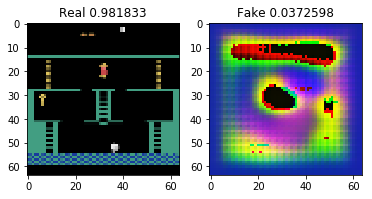

dlr 0.000383 glr 0.000374


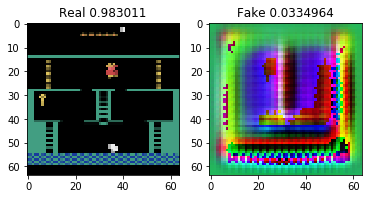

dlr 0.000383 glr 0.000374


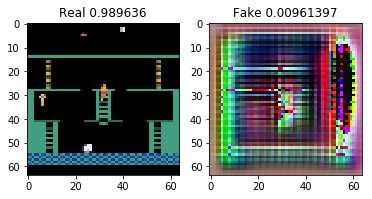

dlr 0.000383 glr 0.000374


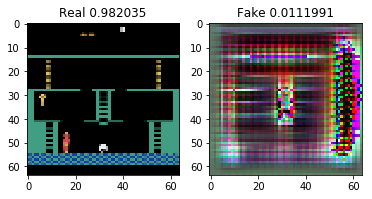

dlr 0.000383 glr 0.000374


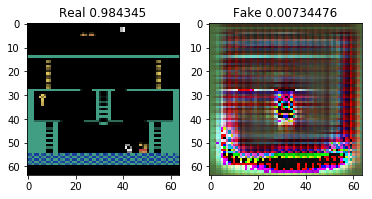

dlr 0.000383 glr 0.000374


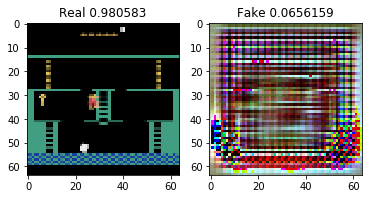

dlr 0.000383 glr 0.000374


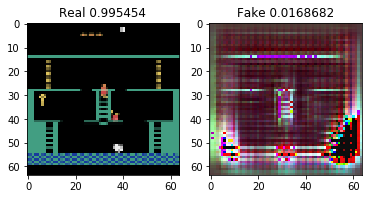

dlr 0.000383 glr 0.000374


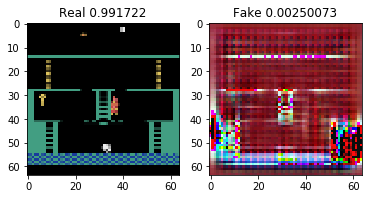

dlr 0.000383 glr 0.000374


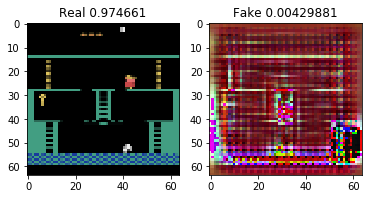

dlr 0.000383 glr 0.000374


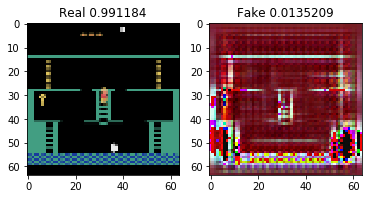

dlr 0.000383 glr 0.000374


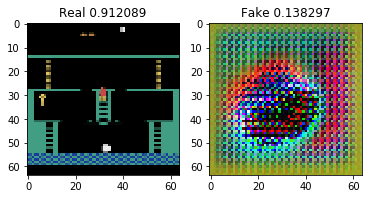

dlr 0.000025 glr 0.000019


KeyboardInterrupt: 

In [19]:
#Find good learning rates
num_tries = 15
llr_min = -5.0
llr_max = -3.2
llr_difference_min = -.5
llr_difference_max = 1.2
d_llr = nd.random.uniform(low=llr_min*math.log(10), high=llr_max*math.log(10), shape=(num_tries, 1))
g_llr = d_llr + nd.random.uniform(low=llr_difference_min*math.log(10), high=llr_difference_max*math.log(10), shape=(num_tries, 1))
d_learning_rates = nd.exp(d_llr)
g_learning_rates = nd.exp(g_llr)
num_epochs_per_try = 10
epoch_size = 210
batch_state_GAN = nd.empty((opt.batch_size_GAN,3,opt.image_size_GAN,opt.image_size_GAN), opt.ctx)

for j in range(num_tries):
    dlr = d_learning_rates[j].asscalar()
    glr = g_learning_rates[j].asscalar()
    discriminator = get_discriminator()
    discriminator.collect_params().initialize(mx.init.Normal(1e-3), ctx=opt.ctx)
    generator = get_generator()
    generator.collect_params().initialize(mx.init.Normal(1e-3), ctx=opt.ctx)
    discriminator_trainer = gluon.Trainer(discriminator.collect_params(),'Adam', {'learning_rate': dlr})
    discriminator.collect_params().zero_grad()
    generator_trainer = gluon.Trainer(generator.collect_params(),'Adam', {'learning_rate': glr})
    generator.collect_params().zero_grad()

    frame_counter = 0
    for i in range(num_epochs_per_try):
        epoch_loss = 0.
        for k in range(epoch_size):
            tmp = replay_memory_GAN.sample(opt.batch_size_GAN)
            for j in range(opt.batch_size_GAN):
                batch_state_GAN[j] = nd.array(tmp[j], opt.ctx)
            loss_disc = StepGAN(batch_state_GAN, discriminator_trainer, generator_trainer, k==epoch_size-1, True)
        epoch_loss += loss_disc

        results = 'dlr %f glr %f'%(dlr, glr)
        print(results)

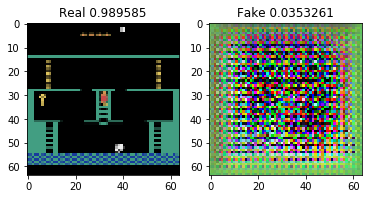

GAN epoch[0] loss 0.048710


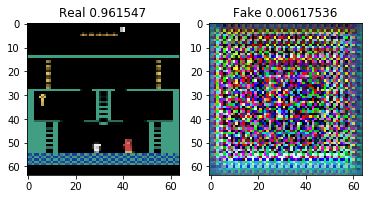

GAN epoch[1] loss 0.063582


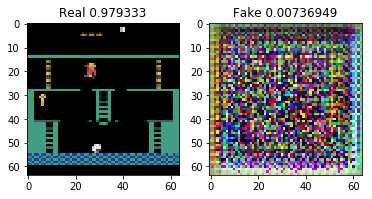

GAN epoch[2] loss 0.619015


In [ ]:
#Roll out good GAN for a while
dlr_best = 0.000383
glr_best = 0.000374

discriminator = get_discriminator()
discriminator.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
generator = get_generator()
generator.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)

discriminator_trainer = gluon.Trainer(discriminator.collect_params(),'Adam', \
                          {'learning_rate': dlr_best})
discriminator.collect_params().zero_grad()
generator_trainer = gluon.Trainer(generator.collect_params(),'Adam', \
                          {'learning_rate': glr_best})
generator.collect_params().zero_grad()

frame_counter = 0
num_epochs = 50
epoch_size = 200
batch_state_GAN = nd.empty((opt.batch_size_GAN,3,opt.image_size_GAN,opt.image_size_GAN), opt.ctx)
for i in range(num_epochs):
    epoch_loss = 0.
    for k in range(epoch_size):
        tmp = replay_memory_GAN.sample(opt.batch_size_GAN)
        for j in range(opt.batch_size_GAN):
            batch_state_GAN[j] = nd.array(tmp[j], opt.ctx)
        loss_disc = StepGAN(batch_state_GAN, discriminator_trainer, generator_trainer, k==epoch_size-1, True)
        epoch_loss += loss_disc

    results = 'GAN epoch[%d] loss %f'%(i, loss_disc)
    print(results)


In [21]:
for param in generator.collect_params():
    local_param = param[len(generator.collect_params().prefix):]
    print(param, generator.collect_params().get(local_param).data().max().asscalar())
    
for param in discriminator.collect_params():
    local_param = param[len(discriminator.collect_params().prefix):]
    print(param, discriminator.collect_params().get(local_param).data().max().asscalar())

sequential71_dense0_weight 0.277874
sequential71_dense0_bias 0.912958
sequential71_conv0_weight 0.23254
sequential71_conv0_bias 0.00128394
sequential71_batchnorm0_gamma 1.19248
sequential71_batchnorm0_beta -0.00371502
sequential71_batchnorm0_running_mean 1.30269
sequential71_batchnorm0_running_var 72.5838
sequential71_conv1_weight 0.561971
sequential71_conv1_bias 0.00406137
sequential71_batchnorm1_gamma 1.28405
sequential71_batchnorm1_beta -0.0447177
sequential71_batchnorm1_running_mean 0.970189
sequential71_batchnorm1_running_var 26.9757
sequential71_conv2_weight 0.408076
sequential71_conv2_bias 0.00924155
sequential71_batchnorm2_gamma 1.31488
sequential71_batchnorm2_beta -0.0179298
sequential71_batchnorm2_running_mean -0.681287
sequential71_batchnorm2_running_var 28.3513
sequential71_conv3_weight 0.423581
sequential71_conv3_bias 0.0328045
sequential71_batchnorm3_gamma 1.06821
sequential71_batchnorm3_beta -0.185807
sequential71_batchnorm3_running_mean 0.498386
sequential71_batchnorm3_

In [85]:


# generator = get_generator()
# generator.load_params("models/good_generator.model_save",opt.ctx)
# discriminator = get_discriminator()
# discriminator.load_params("models/good_discriminator.model_save",opt.ctx)

# discriminator = get_discriminator()
# discriminator.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
# generator = get_generator()
# generator.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)

# discriminator_trainer = gluon.Trainer(discriminator.collect_params(),'Adam', \
#                           {'learning_rate': dlr_best})
# discriminator.collect_params().zero_grad()
# generator_trainer = gluon.Trainer(generator.collect_params(),'Adam', \
#                           {'learning_rate': glr_best})

### Initialize arrays

In [86]:
frame_counter = 0. # Counts the number of steps so far
saved_frame_counter = 0
annealing_count = 0. # Counts the number of annealing steps
epis_count = 0. # Counts the number episodes so far
replay_memory = Replay_Buffer(opt.replay_buffer_size) # Initialize the replay buffer
replay_memory_GAN = Replay_Buffer_GAN(opt.replay_buffer_size_GAN)
tot_clipped_reward = np.zeros(opt.num_episode) 
saved_frame_counter = 0
tot_reward = np.zeros(opt.num_episode)
moving_average_clipped = 0.
moving_average = 0.
loss_disc = 0.
intrinsic_reward = 0.
tot_intrinsic_reward = np.zeros(opt.num_episode)

In [87]:
#render_image = True # Whether to render Frames and show the game
batch_state = nd.empty((opt.batch_size,opt.frame_len,opt.image_size,opt.image_size), opt.ctx)
batch_state_GAN = nd.empty((opt.batch_size_GAN,opt.frame_len,opt.image_size,opt.image_size), opt.ctx)
batch_state_next = nd.empty((opt.batch_size,opt.frame_len,opt.image_size,opt.image_size), opt.ctx)
for i in range(opt.num_episode):
    cum_clipped_reward = 0
    intrinsic_reward = 0
    cum_reward = 0
    next_frame = env.reset()
    state = preprocess(next_frame, initial_state = True)
    t = 0.
    done = False
    

    while not done:
        previous_state = state
        # show the frame
        #renderimage(next_frame)
        sample = random.random()
        if frame_counter > opt.replay_start_size:
            annealing_count += 1
        if frame_counter == opt.replay_start_size:
            print('DQN annealing and learning are started ')
        if frame_counter == opt.replay_start_size_GAN:
            print('GAN learning started')
            
            
        
        eps = np.maximum(1.-annealing_count/opt.annealing_end,opt.epsilon_min)
        effective_eps = eps
        if t < opt.no_op_max:
            effective_eps = 1.
        
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = nd.array(state.reshape([1,opt.frame_len,opt.image_size,opt.image_size]),opt.ctx)
            action = int(nd.argmax(dqn(data),axis=1).as_in_context(mx.cpu()).asscalar())
        
        # Skip frame
        rew = 0
        for skip in range(opt.skip_frame-1):
            next_frame, reward, done,_ = env.step(action)
            #renderimage(next_frame)
            cum_clipped_reward += rew_clipper(reward)
            rew += reward
            for internal_skip in range(opt.internal_skip_frame-1):
                _ , reward, done,_ = env.step(action)
                cum_clipped_reward += rew_clipper(reward)
                rew += reward
                
        next_frame_new, reward, done, _ = env.step(action)
        #renderimage(next_frame)
        cum_clipped_reward += rew_clipper(reward)
        rew += reward
        cum_reward += rew
        
        # Reward clipping
        reward = rew_clipper(rew)
        next_frame = np.maximum(next_frame_new,next_frame)
        state = preprocess(next_frame, state)
        replay_memory_GAN.push(state)
        replay_memory.push((previous_state*255.).astype('uint8'),action,(state*255.).astype('uint8'),reward,done)
     
        if frame_counter % opt.reset_frequency_GAN == 0:
            generator = get_generator()
            discriminator = get_discriminator()
            
        #Train GAN if we must
        if frame_counter % opt.learning_frequency_GAN == 0 and frame_counter > opt.replay_start_size_GAN:
            tmp = replay_memory_GAN.sample(opt.batch_size_GAN)
            for j in range(opt.batch_size_GAN):
                batch_state_GAN[j] = nd.array(tmp[j], opt.ctx)
            loss_disc = StepGAN(batch_state_GAN, discriminator_trainer, generator_trainer, frame_counter % 20000 == 0, True)
#         innovation_scores = 1.-discriminator(batch_state)
#                 index = int(nd.argmax(innovation_scores,axis=0).asscalar())
#                 max_innovation_score = innovation_scores[index].asscalar()
#                 if max_innovation_score < opt.innovation_score_save_threshold:
#                     print(""+str(saved_frame_counter)+" saving frame "+str(frame_counter)+"at t = "+str(t)+" with value "+str(max_innovation_score))
#                     save_frame(batch_state[index], saved_frame_counter)
#                     saved_frame_counter += 1
        #Train Q if we must
        if frame_counter > opt.replay_start_size:
            if frame_counter % opt.learning_frequency == 0:
                transitions = replay_memory.sample(opt.batch_size)
                batch = Transition(*zip(*transitions))
                for j in range(opt.batch_size):
                    batch_state[j] = nd.array(batch.state[j],opt.ctx).astype('float32')/255.
                    batch_state_next[j] = nd.array(batch.next_state[j],opt.ctx).astype('float32')/255.
                innovation_scores = 1.-discriminator(batch_state)
                batch_reward = nd.array(batch.reward,opt.ctx) + opt.intrinsic_beta * innovation_scores
                intrinsic_reward = intrinsic_reward + nd.sum(batch_reward)
                batch_action = nd.array(batch.action,opt.ctx).astype('uint8')
                batch_done = nd.array(batch.done,opt.ctx)
                with autograd.record():
                    Q_sp = nd.max(target_dqn(batch_state_next),axis = 1)
                    Q_sp = Q_sp*(nd.ones(opt.batch_size,ctx = opt.ctx)-batch_done)
                    Q_s_array = dqn(batch_state)
                    Q_s = nd.pick(Q_s_array,batch_action,1)
                    loss = nd.mean(l2loss(Q_s ,  (batch_reward + opt.gamma *Q_sp)))
                loss.backward()
                
        
        t += 1
        frame_counter += 1
        
        # Save the model and update Target model
        if frame_counter > opt.replay_start_size:
            if frame_counter % opt.Target_update == 0 :
                check_point = frame_counter / (opt.Target_update *100)
                fdqn = './target_%s_%d' % (env_name,int(check_point))
                dqn.save_params(fdqn)
                target_dqn.load_params(fdqn, opt.ctx)
        if done:
            if epis_count % 10. == 0. :
                results = 'epis[%d],eps[%f],durat[%d],fnum=%d, cum_cl_rew = %d, cum_rew = %d,tot_cl = %d , tot = %d, loss_disc = %f'\
                  %(epis_count,eps,t+1,frame_counter,cum_clipped_reward,cum_reward,moving_average_clipped,moving_average, loss_disc)
                print(results)
                f.write('\n' + results)
    epis_count += 1
    tot_clipped_reward[int(epis_count)-1] = cum_clipped_reward
    tot_instrinsic_reward[int(epis_count)-1] = intrinsic_reward
    tot_reward[int(epis_count)-1] = cum_reward
    if epis_count > 50.:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count)-1-50:int(epis_count)-1])
        moving_average = np.mean(tot_reward[int(epis_count)-1-50:int(epis_count)-1])
f.close()
from tempfile import TemporaryFile
outfile = TemporaryFile()
outfile_clip = TemporaryFile()
np.save(outfile, moving_average)
np.save(outfile_clip, moving_average_clipped)

KeyboardInterrupt: 

In [ ]:
### Plot the overall performance

In [ ]:
bandwidth = 1000 # Moving average bandwidth
total_clipped = np.zeros(int(epis_count)-bandwidth)
total_rew = np.zeros(int(epis_count)-bandwidth)
for i in range(int(epis_count)-bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i+bandwidth])/bandwidth
    total_rew[i] = np.sum(tot_reward[i:i+bandwidth])/bandwidth
t = np.arange(int(epis_count)-bandwidth)
belplt = plt.plot(t,total_rew[0:int(epis_count)-bandwidth],"r", label = "Return")
plt.legend()#handles[likplt,belplt])
print('Running after %d number of episodes' %epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
likplt = plt.plot(t,total_clipped[0:opt.num_episode-bandwidth],"b", label = "Clipped Return")
plt.legend()#handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()


### Accumulated average reward after 1000 episodes of game Assault
|![](./Assault.png)|![](./Assault-clipped.png)|
|:---------------:|:---------------:|
|Average reward|Average clipped reward|